I tried a meta-learning method in this project. In this technique, first I used a custom ViT (Vision Transformer) model for the feature extraction stage,  then merged the metadata .csv file with the ViT features, then applied PCA for the curse of dimensionality problem, and finally used a CatBoost model for the classification stage.



### <span style="color:#e74c3c;">  ViT Model (for Feature Extraction) -> Merging with .csv file (using for another features) -> PCA (for Dimensionality Reduction) -> CatBoostClassifier (for Classification) </span> 


|                                 | Training Feature Shape |
|---------------------------------|-------------|
| ViT Features                    | (39464, 64)  |
| After PCA (99 % Variance Ratio) | (39464, 42)   |



* I used a mirrored strategy (using 2 T4 GPU at the same time),
* I split the full data into train (39498 images), validation (4389 images) and test (4877 images),
* I used a customized ViT model [1],
* Used <b>tf.data</b> for input pipeline,
* I used a CatBoost model for classification,
* SHAP for feature explanation,


## My Another Projects
* [Bladder Tissue Classification w/ViT (F1 Scr: 0.82)](https://www.kaggle.com/code/banddaniel/bladder-tissue-classification-w-vit-f1-scr-0-82)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)


## References
1. https://github.com/faustomorales/vit-keras

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from vit_keras import vit

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model


import shap
shap.initjs()

IMG_SIZE = 100, 100
BATCH_SIZE = 32
SEED = 99
AUTO = tf.data.AUTOTUNE

In [3]:
# Creatin mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
data = pd.read_csv('/kaggle/input/diamond-images-dataset/web_scraped/diamond_data.csv')
data['full_path_to_img'] = '/kaggle/input/diamond-images-dataset/' + data['path_to_img']
data.head()

,path_to_img,stock_number,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth,full_path_to_img
0,web_scraped/cushion/2106452.jpg,2106452,cushion,0.55,SI2,N,VG,EX,VG,N,GIA,4.56,4.44,3.09,/kaggle/input/diamond-images-dataset/web_scrap...
1,web_scraped/cushion/2042329.jpg,2042329,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99,/kaggle/input/diamond-images-dataset/web_scrap...
2,web_scraped/cushion/2055268.jpg,2055268,cushion,0.50,SI1,L,VG,EX,VG,N,GIA,4.87,4.19,2.89,/kaggle/input/diamond-images-dataset/web_scrap...
3,web_scraped/cushion/2128779.jpg,2128779,cushion,0.50,VS2,M,EX,EX,VG,F,GIA,4.73,4.28,2.84,/kaggle/input/diamond-images-dataset/web_scrap...
4,web_scraped/cushion/2103991.jpg,2103991,cushion,0.51,SI1,M,EX,EX,VG,N,GIA,4.47,4.44,3.05,/kaggle/input/diamond-images-dataset/web_scrap...


In [5]:
# Empty sample and dropping
data[data['full_path_to_img'] == '/kaggle/input/diamond-images-dataset/web_scraped/emerald/220188-630.jpg']
data.drop(8235, axis = 0, inplace = True)

# <span style="color:#e74c3c;"> Preprocessing </span> 

In [6]:
# look-up table
classes = {0:'cushion', 1 : 'emerald', 2 : 'heart', 3 : 'marquise', 4 : 'oval', 5: 'pear', 6: 'princess', 7: 'round'}


# a function for encoding classes
def create_class(X):
    if X == 'cushion':
        return 0
    elif X =='emerald':
        return 1
    elif X == 'heart':
        return 2
    elif X == 'marquise':
        return 3
    elif X == 'oval':
        return 4
    elif X == 'pear':
        return 5
    elif X == 'princess':
        return 6
    elif X == 'round':
        return 7
    else:
        print('error class')


# Encoding classes
data['encoded_class'] = data['shape'].apply(create_class)

# <span style="color:#e74c3c;"> Creating </span> Train, Validation, Test Sets

In [7]:
y = data.pop('encoded_class')
X = data

X_data, X_test, y_data, y_test =  train_test_split(X,y, test_size = 0.1, stratify = y , random_state=SEED, shuffle=True)
X_train, X_val, y_train, y_val =  train_test_split(X_data, y_data, test_size = 0.1, stratify = y_data, random_state=SEED, shuffle=True)


print("train shape -> ", X_train.shape[0])
print("val shape -> ", X_val.shape[0])
print("test shape -> ", X_test.shape[0])

train shape ->  39498
val shape ->  4389
test shape ->  4877


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [8]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 6, seed = SEED)
    
    return img, label

In [9]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train['full_path_to_img'], y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


# Training dataset without shuffling and data augmantation operations for the classification stage
train_loader_feature = tf.data.Dataset.from_tensor_slices((X_train['full_path_to_img'], y_train))
train_dataset_feature = (train_loader_feature
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((X_val['full_path_to_img'], y_val))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test['full_path_to_img'], y_test))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#3498db;"> Feature Extraction </span>

# <span style="color:#e74c3c;"> Custom ViT Model Feature Extractor </span>

In [10]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.build_model(image_size = IMG_SIZE, patch_size = 5, activation = 'softmax', include_top = False,
        classes = 8, num_layers = 5, hidden_size = 128, mlp_dim = 128, num_heads = 2, name = 'my_vit_model')
    
    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(64, activation = 'gelu', name = 'the_feature_layer')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(8, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 4, name = "top_4_acc", dtype=None) ] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 my_vit_model (Functional)   (None, 128)               559360    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 the_feature_layer (Dense)   (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 569960 (2.17 MB)
Trainable params: 569960 (2.17

In [11]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, epochs = 7, batch_size = BATCH_SIZE, validation_data = valid_dataset)
model.save("vit_feature_extractor.h5")

Epoch 1/7
1235/1235 [==============================] - 158s 90ms/step - loss: 1.7192 - acc: 0.4315 - top_4_acc: 0.7652 - val_loss: 1.5873 - val_acc: 0.4249 - val_top_4_acc: 0.8590
Epoch 2/7
1235/1235 [==============================] - 108s 87ms/step - loss: 1.2011 - acc: 0.5814 - top_4_acc: 0.9070 - val_loss: 1.1458 - val_acc: 0.6154 - val_top_4_acc: 0.9376
Epoch 3/7
1235/1235 [==============================] - 108s 87ms/step - loss: 0.6967 - acc: 0.7565 - top_4_acc: 0.9747 - val_loss: 1.0071 - val_acc: 0.6771 - val_top_4_acc: 0.9437
Epoch 4/7
1235/1235 [==============================] - 107s 87ms/step - loss: 0.5287 - acc: 0.8188 - top_4_acc: 0.9863 - val_loss: 1.0289 - val_acc: 0.6951 - val_top_4_acc: 0.9433
Epoch 5/7
1235/1235 [==============================] - 107s 87ms/step - loss: 0.4586 - acc: 0.8436 - top_4_acc: 0.9897 - val_loss: 1.3327 - val_acc: 0.6448 - val_top_4_acc: 0.9184
Epoch 6/7
1235/1235 [==============================] - 108s 87ms/step - loss: 0.4112 - acc: 0.8618 -

In [12]:
# Validation and Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    val_eval_vit = model.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
    print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
138/138 [==============================] - 6s 41ms/step - loss: 1.3906 - acc: 0.6437 - top_4_acc: 0.9214
Validation Loss: 1.391
Validation Accuracy: 64.365 %
----------------------------------------------------------------------------------------------------
153/153 [==============================] - 10s 64ms/step - loss: 1.3957 - acc: 0.6356 - top_4_acc: 0.9233
Test Loss: 1.396
Test Accuracy: 63.564 %


# <span style="color:#e74c3c;"> Classification </span> Stage

In [13]:
# Reading saved model and weights
feature_extr = tf.keras.models.load_model('/kaggle/working/vit_feature_extractor.h5')

# Feature extraction model 
feature_extractor_model = Model(inputs=feature_extr.input,
                                outputs=feature_extr.get_layer('the_feature_layer').output)

In [14]:
# Creating train features

with stg.scope():
    features = feature_extractor_model.predict(train_dataset_feature)

1235/1235 [==============================] - 51s 39ms/step


# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [15]:
# Applying PCA 42 components nearly equal to 0.99 variance ratio

pca_ = PCA(42)
pred_pca_ = pca_.fit(features)
pred_pca = pred_pca_.transform(features)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
train_features = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with a ViT feature extractor 
train_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42
0,-6.059303,-3.327285,0.870771,1.982380,2.496216,-0.424948,0.923069,-0.635070,0.135792,-0.688435,...,-0.157331,-0.054382,-0.271828,-0.414573,-0.301434,-0.265109,0.049474,0.310669,-0.297936,0.156658
1,-5.432613,3.240848,-1.590225,-0.314858,-0.553562,-3.683427,0.356051,1.887136,1.036284,-0.916661,...,-0.076143,-0.305534,-0.422571,-0.004210,-0.581397,0.127466,0.398602,0.295203,-0.264926,-0.019001
2,3.537448,-6.217684,0.243224,1.107243,-1.914675,-1.453212,-2.131891,0.653393,-0.477989,0.109830,...,-0.430819,-0.417039,0.263773,0.069456,-0.075126,-0.090559,-0.165094,0.275967,-0.353589,0.024325
3,-0.410747,-1.138120,-5.374403,2.485319,1.956027,-0.319208,-0.611163,-1.056933,-0.969054,0.604596,...,0.040277,-0.174286,0.871128,0.485181,0.584882,0.027731,-0.090222,0.301771,0.323264,-0.152149
4,-3.842340,-4.653476,-3.064174,0.519758,3.579352,1.463819,-1.403741,0.456826,-0.788042,1.271157,...,0.410176,-0.378819,0.189530,0.381206,0.125944,0.322145,0.201472,0.380876,0.008928,0.260701


In [16]:
# Merging the deep learning features with meta data features

X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
train_data_last = pd.concat([X_train, train_features, y_train], axis = 1)

# Dropping a few null features
train_data_last.drop(['full_path_to_img', 'path_to_img', 'stock_number', 'shape', 'lab', 'cut'], axis = 1, inplace = True)
train_data_last.head()

,carat,clarity,colour,polish,symmetry,fluorescence,length,width,depth,feature_1,...,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,encoded_class
0,0.70,VS2,K,EX,EX,F,5.64,5.68,3.50,-6.059303,...,-0.054382,-0.271828,-0.414573,-0.301434,-0.265109,0.049474,0.310669,-0.297936,0.156658,7
1,3.01,VS2,F,EX,EX,N,9.17,9.23,5.76,-5.432613,...,-0.305534,-0.422571,-0.004210,-0.581397,0.127466,0.398602,0.295203,-0.264926,-0.019001,7
2,1.20,I1,E,EX,GD,F,7.83,5.70,3.88,3.537448,...,-0.417039,0.263773,0.069456,-0.075126,-0.090559,-0.165094,0.275967,-0.353589,0.024325,4
3,0.70,VS2,I,EX,VG,N,7.37,4.84,3.17,-0.410747,...,-0.174286,0.871128,0.485181,0.584882,0.027731,-0.090222,0.301771,0.323264,-0.152149,5
4,0.55,VVS2,K,EX,EX,ST,5.21,5.24,3.28,-3.842340,...,-0.378819,0.189530,0.381206,0.125944,0.322145,0.201472,0.380876,0.008928,0.260701,7


In [17]:
# Encoding nominal features
enc1 = OrdinalEncoder()

train_data_last['clarity'] = enc1.fit_transform(np.array(train_data_last['clarity']).reshape(-1,1))
train_data_last['colour'] = enc1.fit_transform(np.array(train_data_last['colour']).reshape(-1,1))
train_data_last['polish'] = enc1.fit_transform(np.array(train_data_last['polish']).reshape(-1,1))
train_data_last['symmetry'] = enc1.fit_transform(np.array(train_data_last['symmetry']).reshape(-1,1))
train_data_last['fluorescence'] = enc1.fit_transform(np.array(train_data_last['fluorescence']).reshape(-1,1))

# Dropping several NaN values
train_data_last.dropna(inplace = True)

# <span style="color:#e74c3c;"> Classification Catboost </span> Model

In [18]:
y_train = train_data_last.pop('encoded_class')
X_train = train_data_last

# CatBoostClassifier model
cat_model = CatBoostClassifier(verbose = 250)

# Training CatBoost model with features from the ViT feature extractor
cat_model.fit(X_train, y_train)

Learning rate set to 0.09544
0:	learn: 1.7315588	total: 177ms	remaining: 2m 56s
250:	learn: 0.0886993	total: 20.2s	remaining: 1m
500:	learn: 0.0564913	total: 38s	remaining: 37.9s
750:	learn: 0.0409429	total: 56.6s	remaining: 18.8s
999:	learn: 0.0326261	total: 1m 14s	remaining: 0us


In [19]:
# Test set processing
# test feature exteaction -> applying PCA -> predictions of the CatBoostClassifier model

with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_features = pca_.transform(test_features)
test_features = pd.DataFrame(test_features, columns = new_feature_column_names)


X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
test_data_last = pd.concat([X_test, test_features, y_test], axis = 1)
test_data_last.drop(['full_path_to_img', 'path_to_img', 'stock_number', 'shape', 'lab', 'cut'], axis = 1, inplace = True)

test_data_last['clarity'] = enc1.fit_transform(np.array(test_data_last['clarity']).reshape(-1,1))
test_data_last['colour'] = enc1.fit_transform(np.array(test_data_last['colour']).reshape(-1,1))
test_data_last['polish'] = enc1.fit_transform(np.array(test_data_last['polish']).reshape(-1,1))
test_data_last['symmetry'] = enc1.fit_transform(np.array(test_data_last['symmetry']).reshape(-1,1))
test_data_last['fluorescence'] = enc1.fit_transform(np.array(test_data_last['fluorescence']).reshape(-1,1))
test_data_last.dropna(inplace = True)

y_test = test_data_last.pop('encoded_class')
X_test = test_data_last

test_pred = cat_model.predict(X_test)

153/153 [==============================] - 6s 39ms/step


# <span style="color:#e74c3c;"> Test  </span> Results

In [20]:
# Predictions and scores

mse = mean_squared_error(y_test, test_pred)
f1 = f1_score(y_test, test_pred, average = 'weighted')
acc = accuracy_score(y_test, test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

Mean Squared Error : 0.27534
Weighted F1 Score : 0.979
Accuracy Score : 97.887 %


# <span style="color:#e74c3c;"> Test Classification </span> Report

In [21]:
# classification report

clf_report = classification_report(y_test, test_pred, target_names = list(classes.values()))
print(clf_report)

              precision    recall  f1-score   support

     cushion       0.97      0.96      0.96       532
     emerald       1.00      0.99      0.99       339
       heart       1.00      0.99      0.99       376
    marquise       0.98      0.96      0.97        47
        oval       0.94      0.96      0.95       649
        pear       0.94      0.92      0.93       433
    princess       0.95      0.96      0.96       395
       round       1.00      1.00      1.00      2103

    accuracy                           0.98      4874
   macro avg       0.97      0.97      0.97      4874
weighted avg       0.98      0.98      0.98      4874



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

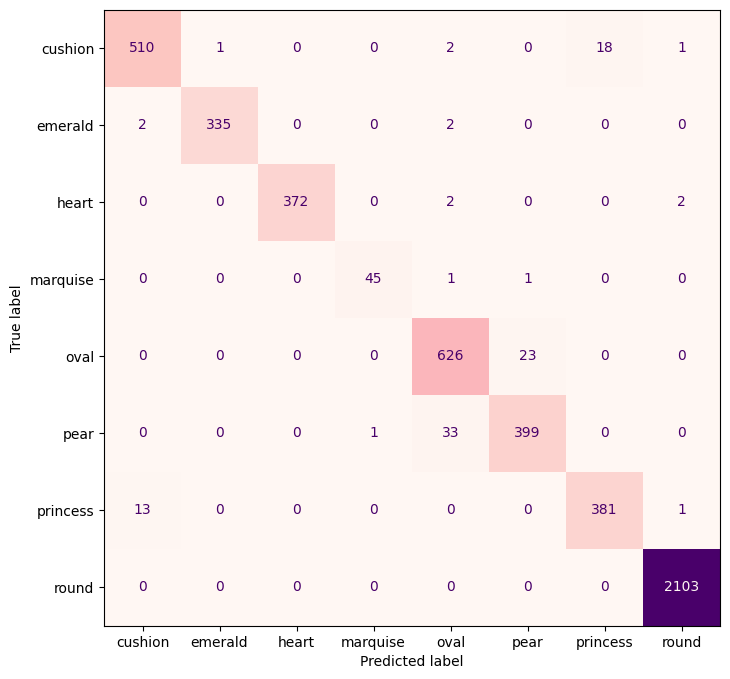

In [22]:
cm = confusion_matrix(y_test, test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values())) 

fig, ax = plt.subplots(figsize=(8,8))
cmd.plot(ax=ax, cmap = 'RdPu', colorbar = False)

# <span style="color:#e74c3c;"> Feature Explanation </span> w/SHAP

In [23]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer(pd.DataFrame(X_test, columns = X_test.columns))

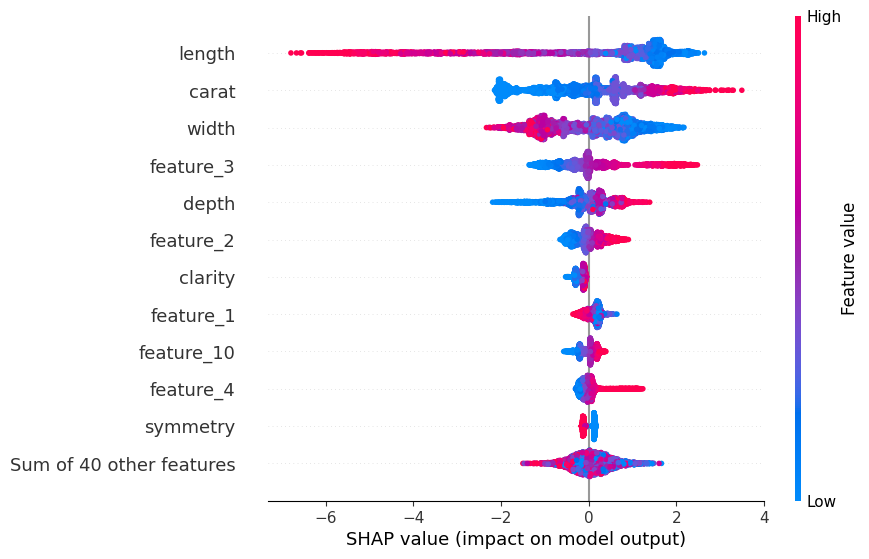

In [24]:
# cushion class feature explanation
shap.plots.beeswarm(shap_values[..., 0], max_display = 12)

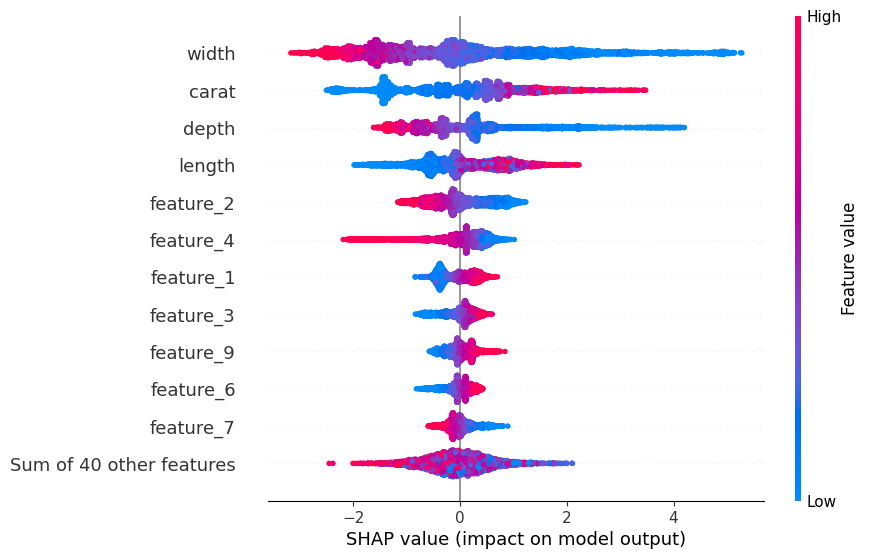

In [25]:
# emerald class feature explanation
shap.plots.beeswarm(shap_values[..., 1], max_display = 12)

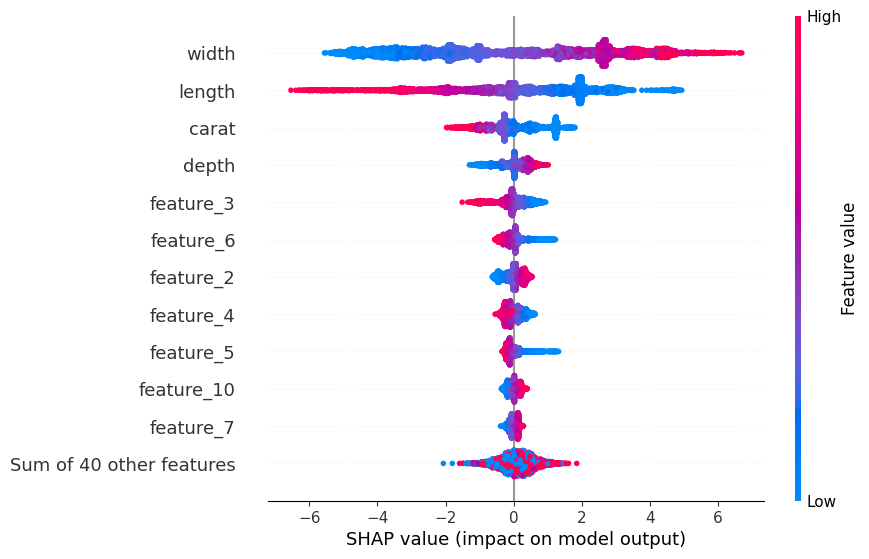

In [26]:
# heart class feature explanation
shap.plots.beeswarm(shap_values[..., 2], max_display = 12)

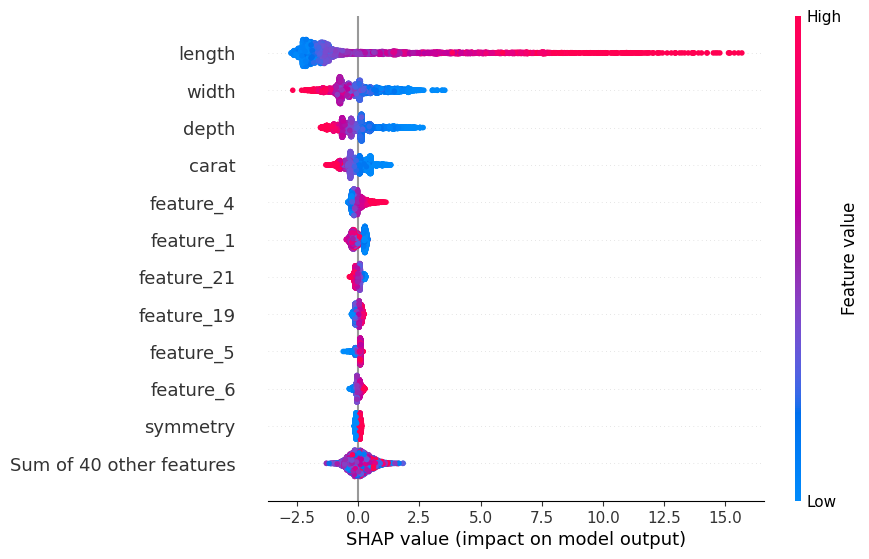

In [27]:
# marquise class feature explanation
shap.plots.beeswarm(shap_values[..., 3], max_display = 12)

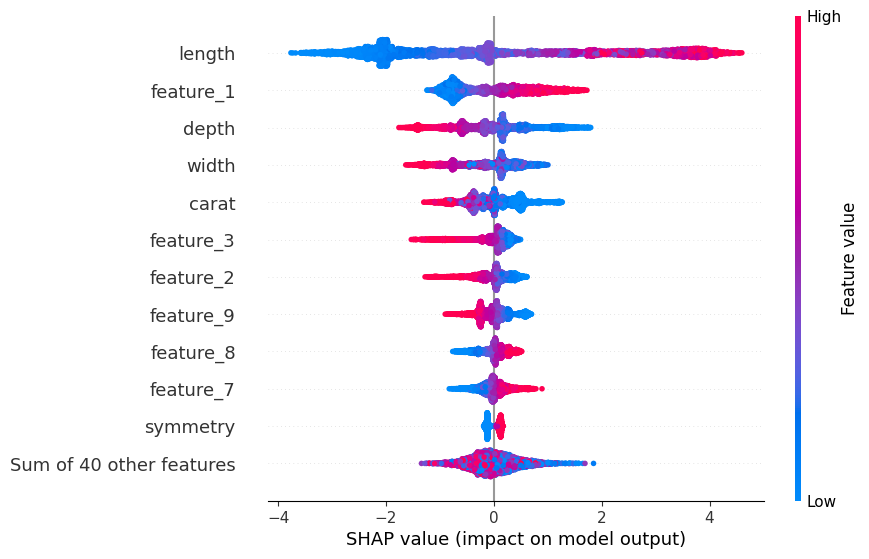

In [28]:
# oval class feature explanation
shap.plots.beeswarm(shap_values[..., 4], max_display = 12)

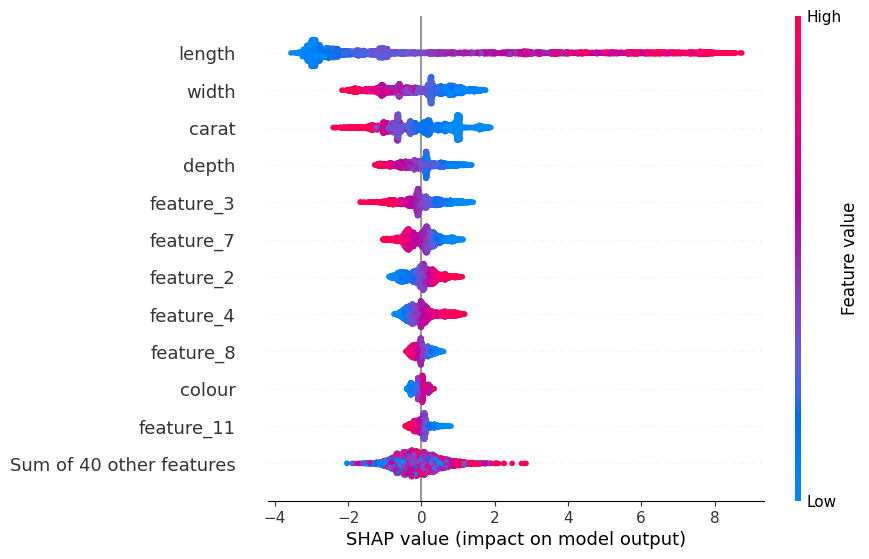

In [29]:
# pear class feature explanation
shap.plots.beeswarm(shap_values[..., 5], max_display = 12)

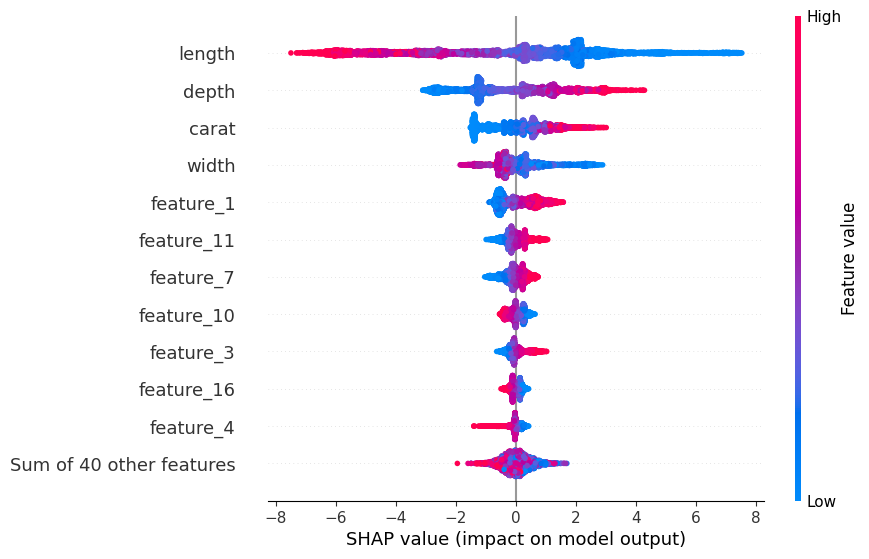

In [30]:
# princess class feature explanation
shap.plots.beeswarm(shap_values[..., 6], max_display = 12)

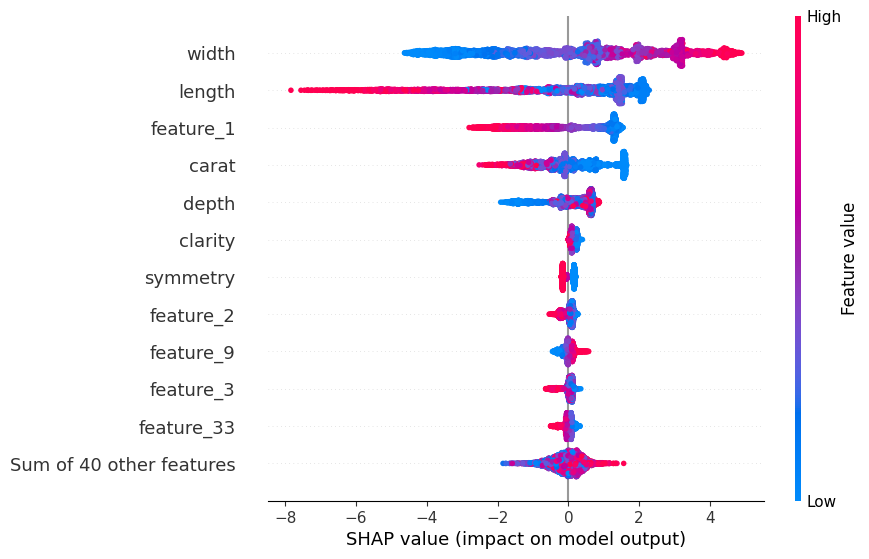

In [31]:
# round class feature explanation
shap.plots.beeswarm(shap_values[..., 7], max_display = 12)

# <span style="color:#e74c3c;"> Test Sample</span> Prediction

In [32]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
        
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

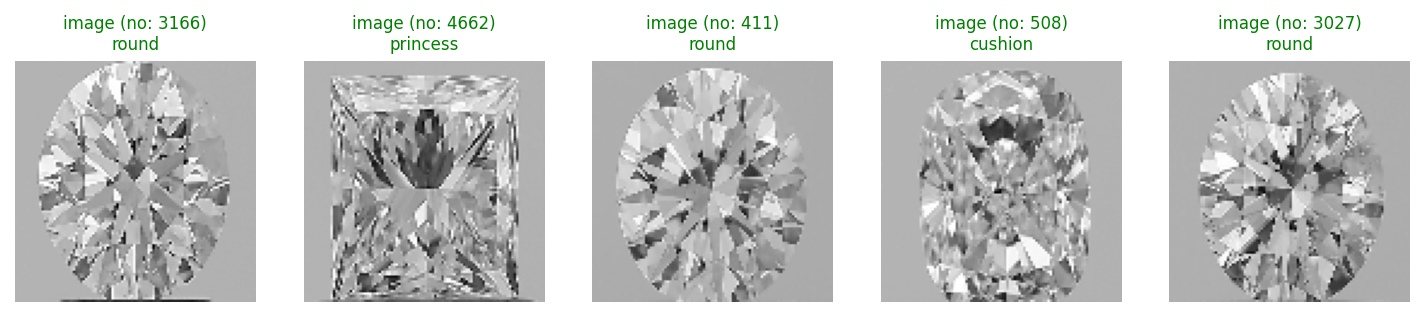

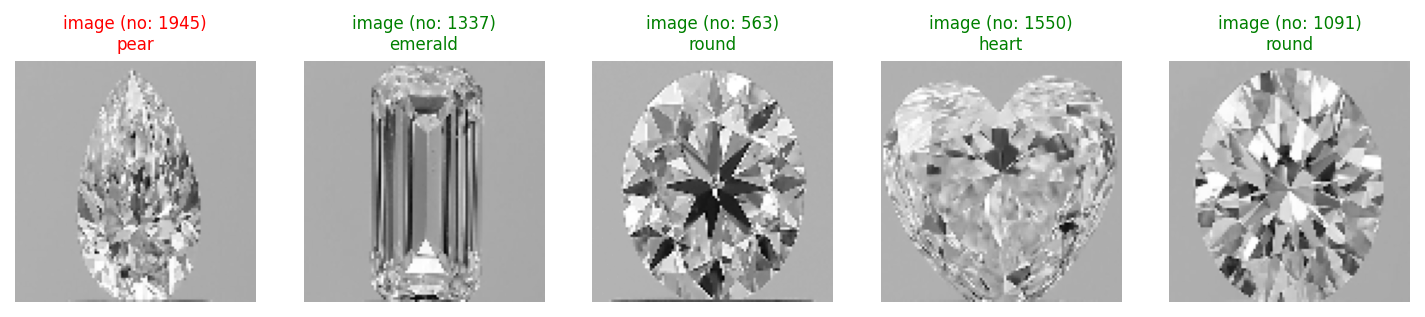

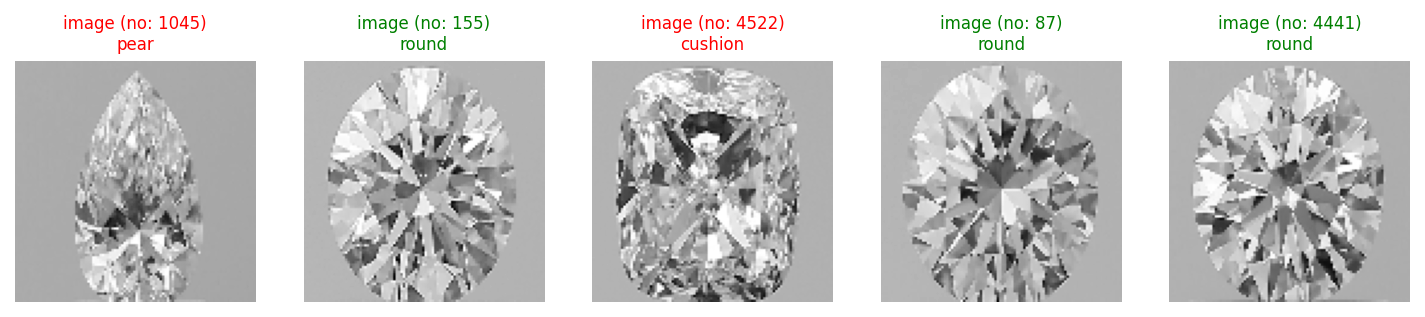

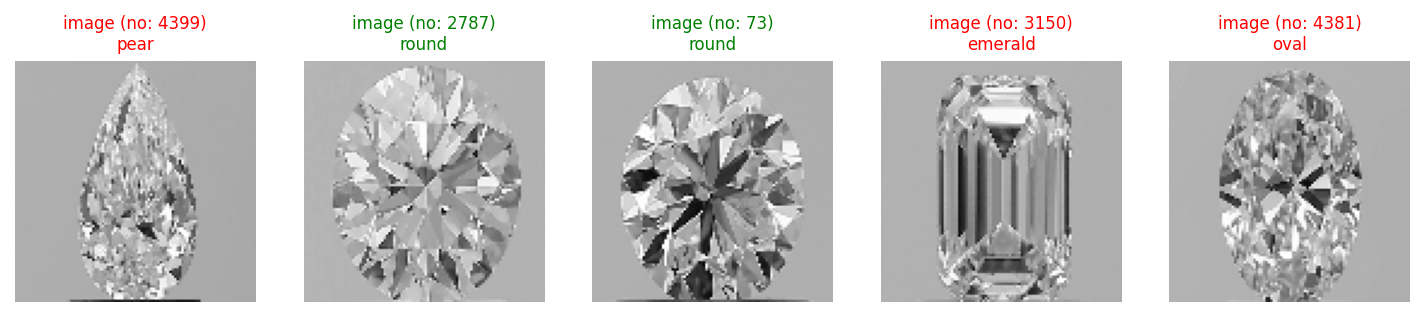

In [33]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 140)
random_test_sample_with_prediction(SEED = 20)
random_test_sample_with_prediction(SEED = 30)
random_test_sample_with_prediction(SEED = 99)